DCNN

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# 1. CIFAR-10 데이터셋 로드
# CIFAR-10 데이터셋은 10개의 클래스(비행기, 자동차, 새 등)를 포함한 32x32 크기의 이미지들로 구성
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 데이터 정규화: 픽셀 값을 0~1 사이로 스케일링
# CIFAR-10 데이터는 0~255 범위의 픽셀 값을 가지므로, 255로 나누어 0~1 범위로 정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 레이블을 원-핫 인코딩
# 0~9의 정수 형태를 10차원의 벡터로 변환합니다.
# to_categorical 함수는 num_classes 매개변수로 클래스를 명시할 수 있으며, 기본값은 데이터에서 자동으로 추정됩니다.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step


In [2]:
# 2. 사전 학습된 VGG16 모델 로드
# VGG16 모델을 불러옴
# include_top=False로 설정하여 마지막 Fully Connected Layer를 제거
# weights='imagenet'은 ImageNet 데이터셋으로 학습된 가중치를 사용
# input_shape는 입력 데이터의 형상을 정의하며
# (32, 32, 3)은 CIFAR-10 데이터셋에 맞는 크기입니다.
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# 모델의 가중치를 고정 (전이 학습용)
# trainable=False로 설정하면 VGG16의 가중치가 고정되어 업데이트되지 않습니다.
vgg16_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [3]:
# 3. 새로운 모델 정의
# VGG16의 출력 위에 우리의 새로운 분류기를 추가
# Sequential 모델은 레이어를 순차적으로 쌓아올리는 단순한 방식의 모델
model = models.Sequential([
    vgg16_base, # 사전 학습된 VGG16 모델
    layers.Flatten(), # 평탄화: 다차원 데이터를 1차원으로 변환
    layers.Dense(256, activation='relu'), # Fully Connected Layer 추가, 256개의 뉴런 사용
    # activation: 활성화 함수, 'relu' 외에도 'sigmoid', 'tanh' 등
    layers.Dropout(0.5), # 드롭아웃: 과적합 방지를 위해 일부 뉴런을 무작위로 비활성화
    # rate: 드롭아웃 비율, 0.5는 50%의 뉴런을 비활성화
    layers.Dense(10, activation='softmax') # CIFAR-10 클래스에 맞는 출력, 10개의 뉴런과 softmax 활성화 함수
    # softmax는 출력값을 확률로 변환하여 다중 클래스 분류에 사용
])
# 모델 컴파일
# optimizer: 최적화 알고리즘, 'adam', 'sgd', 'rmsprop' 등
# loss: 손실 함수, 다중 클래스 분류에서는 'categorical_crossentropy'를 사용
# metrics: 평가 지표, 'accuracy' 외에도 'precision', 'recall' 등을 추가할 수 있음
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [6]:
# 4. 모델 학습
# fit 함수는 모델을 학습시키는 데 사용
# validation_data: 검증 데이터 (x_test, y_test)를 지정하여 학습 중 검증 정확도를 확인
history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=5, batch_size=64)
# epochs: 학습 반복 횟수, 기본값은 1
# batch_size: 한 번에 학습에 사용하는 데이터 샘플 수, 기본값은 32

Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 261s 334ms/step - accuracy: 0.5331 - loss: 1.3302 - val_accuracy: 0.5697 - val_loss: 1.2369
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 274s 351ms/step - accuracy: 0.5579 - loss: 1.2621 - val_accuracy: 0.5831 - val_loss: 1.1910
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 256s 327ms/step - accuracy: 0.5733 - loss: 1.2157 - val_accuracy: 0.5873 - val_loss: 1.1766
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 241s 308ms/step - accuracy: 0.5830 - loss: 1.1946 - val_accuracy: 0.5934 - val_loss: 1.1570
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 255s 326ms/step - accuracy: 0.5995 - loss: 1.1629 - val_accuracy: 0.6012 - val_loss: 1.1448


In [7]:
# 5. Fine-Tuning (세부 조정)
# VGG16의 일부 층을 학습 가능하도록 설정
for layer in vgg16_base.layers[-4:]: # 마지막 4개 층만 학습 가능하도록 설정
    layer.trainable = True

# 모델 재컴파일 (Fine-Tuning 적용 후)
# 학습률(learning_rate)을 낮추어 가중치를 더 세밀하게 조정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-Tuning 학습 진행
fine_tune_history = model.fit(x_train, y_train, 
                              validation_data=(x_test, y_test), 
                              epochs=3, 
                              batch_size=64)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 489s 624ms/step - accuracy: 0.6232 - loss: 1.0785 - val_accuracy: 0.6594 - val_loss: 0.9679
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 399s 510ms/step - accuracy: 0.6732 - loss: 0.9211 - val_accuracy: 0.6823 - val_loss: 0.9031
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 380s 486ms/step - accuracy: 0.7158 - loss: 0.8129 - val_accuracy: 0.6973 - val_loss: 0.8694


In [8]:
# 6. 모델 평가
# 학습 후 테스트 데이터셋에서 모델 성능 평가
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 128ms/step - accuracy: 0.7023 - loss: 0.8627
Test Loss: 0.8694159984588623
Test Accuracy: 0.6973000168800354


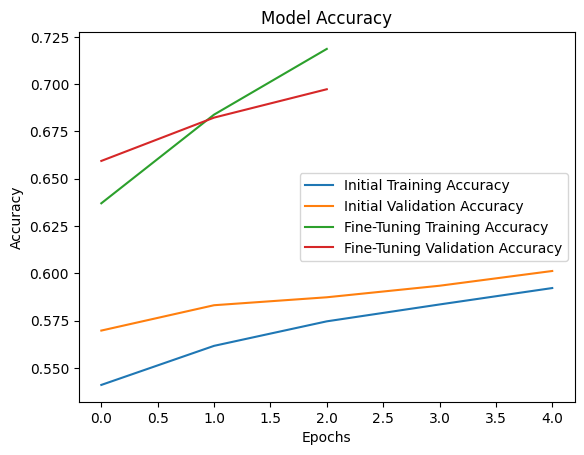

In [9]:
# 7. 결과 시각화
import matplotlib.pyplot as plt
# 학습 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Initial Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tuning Training Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tuning Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()